# **image to image search for music instrumentals**

In [1]:
!pip install transformers Pillow kaggle qdrant_client chromadb

INFO: pip is looking at multiple versions of chromadb to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
import os
import torch
import chromadb
from PIL import Image
import pandas as pd
from transformers import CLIPModel, CLIPProcessor
from chromadb.config import Settings

**Download dataset from kaggle and review it**

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vafaknm","key":"1bed6eb652a5478705dd72efefcd112d"}'}

In [4]:
! chmod 600 /content/kaggle.json

In [5]:
!kaggle datasets download -d gpiosenka/musical-instruments-image-classification

!unzip "musical-instruments-image-classification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: test/harmonica/4.jpg    
  inflating: test/harmonica/5.jpg    
  inflating: test/harp/1.jpg         
  inflating: test/harp/2.jpg         
  inflating: test/harp/3.jpg         
  inflating: test/harp/4.jpg         
  inflating: test/harp/5.jpg         
  inflating: test/marakas/1.jpg      
  inflating: test/marakas/2.jpg      
  inflating: test/marakas/3.jpg      
  inflating: test/marakas/4.jpg      
  inflating: test/marakas/5.jpg      
  inflating: test/ocarina/1.jpg      
  inflating: test/ocarina/2.jpg      
  inflating: test/ocarina/3.jpg      
  inflating: test/ocarina/4.jpg      
  inflating: test/ocarina/5.jpg      
  inflating: test/piano/1.jpg        
  inflating: test/piano/2.jpg        
  inflating: test/piano/3.jpg        
  inflating: test/piano/4.jpg        
  inflating: test/piano/5.jpg        
  inflating: test/saxaphone/1.jpg    
  inflating: test/saxaphone/2.jpg    
  inflating: test/saxaphone/3.jpg    

In [6]:
df = pd.read_csv("/content/instruments.csv")
df

,filepaths,labels,data set
0,train/acordian/001.jpg,acordian,train
1,train/acordian/002.jpg,acordian,train
2,train/acordian/003.jpg,acordian,train
3,train/acordian/004.jpg,acordian,train
4,train/acordian/005.jpg,acordian,train
...,...,...,...
5088,valid/Xylophone/1.jpg,Xylophone,valid
5089,valid/Xylophone/2.jpg,Xylophone,valid
5090,valid/Xylophone/3.jpg,Xylophone,valid
5091,valid/Xylophone/4.jpg,Xylophone,valid


In [7]:
def show_image(image_path):
  image = Image.open(image_path).convert("RGB")
  return image

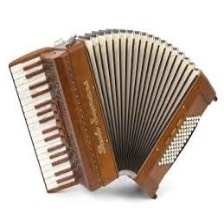

In [8]:
show_image(df.iloc[74]['filepaths'])

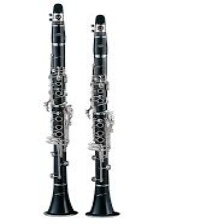

In [9]:
show_image(df.iloc[1234]['filepaths'])

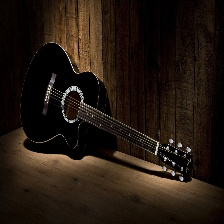

In [10]:
show_image(df.iloc[2500]['filepaths'])

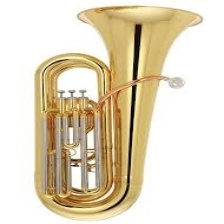

In [11]:
show_image(df.iloc[4322]['filepaths'])

**Creating search model**

In [12]:
# Initialize CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# Connect to Chroma (database) - Using the new initialization method
client = chromadb.Client()

# Create or get the collection
collection_name = "image_collection"
collection = client.get_or_create_collection(name=collection_name)

In [15]:
# Extract image embeddings using CLIP
def extract_embeddings(image_paths):
    embeddings = []
    for image_path in image_paths:
        try:
            image = Image.open(image_path).convert("RGB")

            # Generate a unique image ID based on the path (ensure no directory slashes)
            image_id = os.path.splitext(image_path)[0].replace("/", "_")
            inputs = processor(text=None, images=image, return_tensors="pt")["pixel_values"]  # Prepare inputs for CLIP model

            # Move inputs to GPU
            inputs = inputs.to(device)

            # Extract image features using CLIP model (on GPU)
            image_embedding = model.get_image_features(inputs).detach().squeeze(0).cpu().numpy()

            embeddings.append((image_id, image_embedding))

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue  # Skip images that cannot be processed

    return embeddings

In [16]:
# Store embeddings in Chroma
def create_chroma_vector_store(image_paths):
    embeddings_with_ids = extract_embeddings(image_paths)

    # Add the embeddings to Chroma collection
    for image_id, embedding in embeddings_with_ids:
        collection.add(
            documents=[image_id],  # The document text (use image_id or any other metadata as text)
            embeddings=[embedding.tolist()],  # Chroma expects embeddings to be a list of lists
            metadatas=[{"path": image_id}],  # Optional metadata (e.g., the image path)
            ids=[image_id]  # Use image_id as the unique identifier
        )
    print(f"Stored {len(embeddings_with_ids)} embeddings in ChromaDB.")

In [17]:
# Example image paths (you can replace this with your actual image paths)
images_path = list(df[df['data set'] == 'train'].filepaths)

# Create vector store in ChromaDB
create_chroma_vector_store(images_path)

Stored 4793 embeddings in ChromaDB.


In [41]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Searching for a query image and displaying similar images
def search_chroma(query_image_path, top_k=5):
    try:
        # Extract the query image embedding
        query_image = Image.open(query_image_path).convert("RGB")
        inputs = processor(text=None, images=query_image, return_tensors="pt")["pixel_values"]
        inputs = inputs.to(device)
        query_embedding = model.get_image_features(inputs).detach().squeeze(0).cpu().numpy()

        # Perform the search in ChromaDB
        results = collection.query(
            query_embeddings=[query_embedding.tolist()],
            n_results=top_k
        )

        # Extract the top `k` matching image paths or file names
        matches = results['documents'][0]
        distances = results['distances'][0]

        # Print the results (matching images)
        print("Top matches:")
        for i, (match, distance) in enumerate(zip(matches, distances)):
            print(f"Match {i+1}: {match} (Distance: {distance:.4f})")

        # Define the base directory where your images are located
        base_image_dir = "/content/train"  # Adjust this if needed

        # Display the query image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, top_k+1, 1)
        plt.imshow(query_image)
        plt.title("Query Image")
        plt.axis('off')

        # Display the top-k similar images
        for i, match in enumerate(matches):
            # Convert underscores to slashes and append .jpg at the end
            image_name = match.replace('_', '/') + '.jpg'  # Convert _ to / and append .jpg

            # Check if the file exists before trying to open it
            if os.path.exists(image_name):
                matched_image = Image.open(image_name).convert("RGB")
            else:
                print(f"Warning: Image not found at {image_name}")
                continue  # Skip if image doesn't exist

            plt.subplot(1, top_k+1, i+2)
            plt.imshow(matched_image)
            plt.title(f"Match {i+1}")
            plt.axis('off')

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"Error during search: {e}")

Top matches:
Match 1: train_acordian_033 (Distance: 12.0889)
Match 2: train_acordian_009 (Distance: 14.7864)
Match 3: train_acordian_040 (Distance: 18.0819)
Match 4: train_acordian_001 (Distance: 18.9769)
Match 5: train_acordian_034 (Distance: 19.2812)


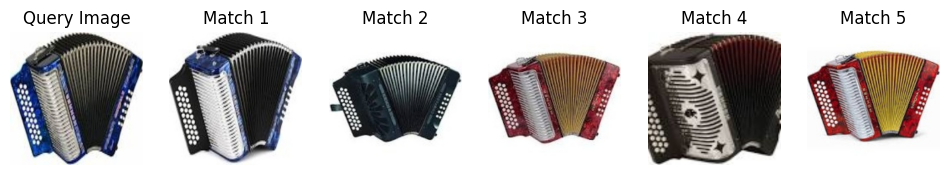

In [42]:
# Example: Search for a query image
test_images_path = list(df[df['data set'] == 'test'].filepaths)

search_chroma(test_images_path[0])

Top matches:
Match 1: train_bagpipes_065 (Distance: 27.9255)
Match 2: train_bagpipes_130 (Distance: 28.0665)
Match 3: train_bagpipes_059 (Distance: 28.5115)
Match 4: train_bagpipes_013 (Distance: 29.4115)
Match 5: train_bagpipes_024 (Distance: 31.0327)


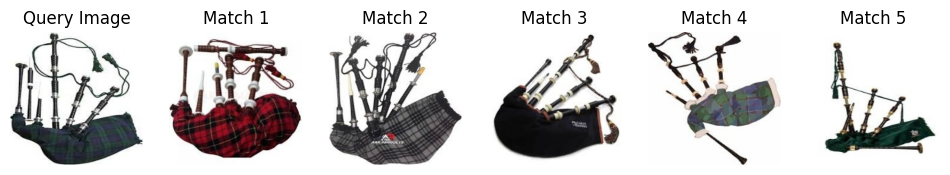

In [43]:
# Example: Search for a query image
test_images_path = list(df[df['data set'] == 'test'].filepaths)

search_chroma(test_images_path[10])

Top matches:
Match 1: train_bongo drum_135 (Distance: 27.0016)
Match 2: train_bongo drum_058 (Distance: 28.6612)
Match 3: train_steel drum_008 (Distance: 31.3297)
Match 4: train_bongo drum_112 (Distance: 32.0828)
Match 5: train_bongo drum_136 (Distance: 33.2631)


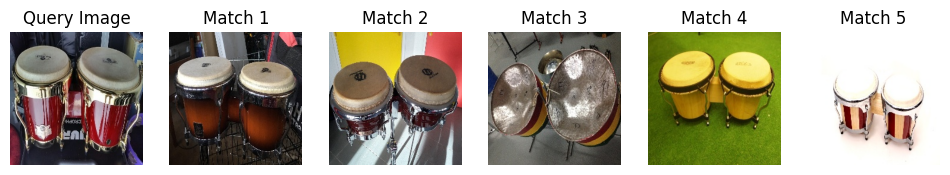

In [44]:
# Example: Search for a query image
test_images_path = list(df[df['data set'] == 'test'].filepaths)

search_chroma(test_images_path[20])

Top matches:
Match 1: train_castanets_018 (Distance: 7.0800)
Match 2: train_castanets_092 (Distance: 12.3591)
Match 3: train_castanets_067 (Distance: 12.9642)
Match 4: train_castanets_096 (Distance: 13.5416)
Match 5: train_castanets_111 (Distance: 16.5705)


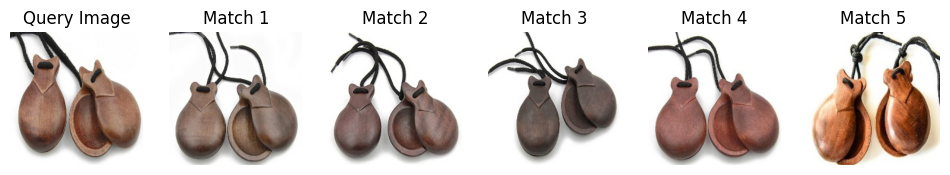

In [45]:
# Example: Search for a query image
test_images_path = list(df[df['data set'] == 'test'].filepaths)

search_chroma(test_images_path[30])

Top matches:
Match 1: train_clavichord_183 (Distance: 20.2386)
Match 2: train_clavichord_194 (Distance: 22.8074)
Match 3: train_clavichord_136 (Distance: 23.9478)
Match 4: train_clavichord_076 (Distance: 24.0996)
Match 5: train_clavichord_131 (Distance: 25.1074)


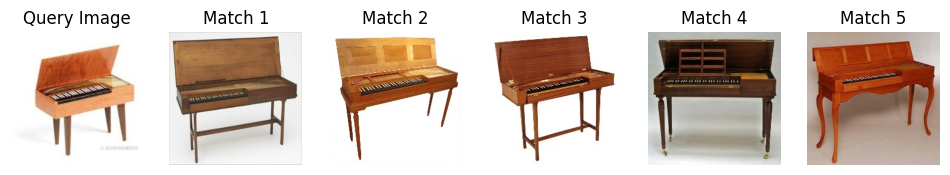

In [46]:
# Example: Search for a query image
test_images_path = list(df[df['data set'] == 'test'].filepaths)

search_chroma(test_images_path[40])

Top matches:
Match 1: train_dulcimer_020 (Distance: 20.5578)
Match 2: train_guitar_110 (Distance: 21.2832)
Match 3: train_dulcimer_055 (Distance: 22.9653)
Match 4: train_dulcimer_083 (Distance: 24.8495)
Match 5: train_dulcimer_120 (Distance: 25.2529)


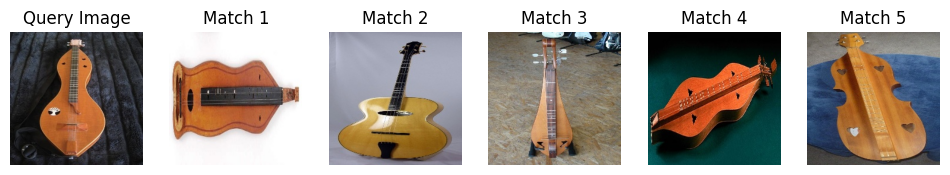

In [47]:
# Example: Search for a query image
test_images_path = list(df[df['data set'] == 'test'].filepaths)

search_chroma(test_images_path[60])